## Importing Packages

In [1]:
import pandas as pd
import pandas_gbq
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import jax.numpy as jnp
import numpyro
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils
from lightweight_mmm import media_transforms
pd.set_option ('display.max_columns', None)

## Data Preparation

In [2]:
df = pd.read_csv('bike_sales_data.csv')
df['Week'] = pd.to_datetime(df['Week'], format='%m/%d/%y')
df.columns = [col.replace('_spend', '') for col in df.columns]
df.drop(columns=['branded_search'], axis=1, inplace=True) # dropped due to high correlation with facebook spends
df

,Week,sales,nonbranded_search,facebook,print,ooh,tv,radio
0,2017-07-23,58850.0000,463.3200,802.6200,0,0,0,0
1,2017-07-30,62050.0000,468.0000,819.3120,0,0,0,0
2,2017-08-06,59388.0000,477.3600,749.0340,0,0,0,0
3,2017-08-13,56964.0000,468.0000,741.4680,0,0,0,0
4,2017-08-20,53460.0000,458.6400,811.2000,0,0,0,0
...,...,...,...,...,...,...,...,...
255,2022-06-12,98173.4880,814.9285,1715.8284,1000,0,2500,0
256,2022-06-19,104221.7248,829.0855,1802.8296,0,0,2500,0
257,2022-06-26,103283.6800,793.6930,1631.2296,0,0,2500,0
258,2022-07-03,105279.5200,829.0855,1855.8540,0,0,2500,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Week               260 non-null    datetime64[ns]
 1   sales              260 non-null    float64       
 2   nonbranded_search  260 non-null    float64       
 3   facebook           260 non-null    float64       
 4   print              260 non-null    int64         
 5   ooh                260 non-null    int64         
 6   tv                 260 non-null    int64         
 7   radio              260 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(4)
memory usage: 16.4 KB


In [4]:
df.columns

Index(['Week', 'sales', 'nonbranded_search', 'facebook', 'print', 'ooh', 'tv',
       'radio'],
      dtype='object')

In [5]:
# Meida Investments 
mdsp_cols = [ 'nonbranded_search','facebook', 
             'print', 'ooh', 'tv', 'radio']
df[mdsp_cols].sum()

nonbranded_search    104619.7725
facebook             263968.3273
print                 98000.0000
ooh                   49000.0000
tv                    72500.0000
radio                136000.0000
dtype: float64

In [6]:
# Totla media investment and sales
print ('total-media-spends:', df[mdsp_cols].sum().sum())
print ('total-sales:', df.sales.sum())

total-media-spends: 724088.0998
total-sales: 17707963.9252


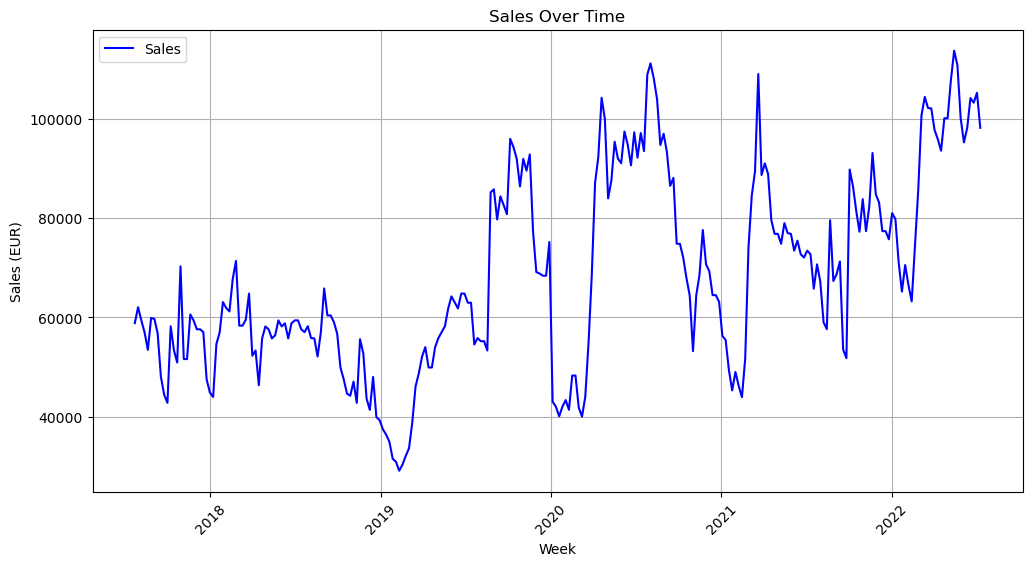

In [7]:
# Sales time series plot
plt.figure(figsize=(12, 6))
plt.plot(df['Week'], df['sales'], linestyle='-', color='b', label='Sales')
plt.xlabel("Week")
plt.ylabel("Sales (EUR)")
plt.title("Sales Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Save the plot 
plt.savefig("sales_timeseries.jpg", format='jpg', dpi=300, bbox_inches='tight')
plt.show()


In [8]:
df.sales.describe()

count       260.000000
mean      68107.553558
std       19608.831323
min       29088.000000
25%       54405.000000
50%       64442.070000
75%       83872.112000
max      113762.880000
Name: sales, dtype: float64

In [9]:
# save the descriptive table
# Example: describe stats (use your actual df instead)
desc = df.sales.describe().round(2)
desc_df = pd.DataFrame(desc)

fig, ax = plt.subplots()
fig.patch.set_facecolor('white')  
ax.axis('off')

# Create table
table = ax.table(cellText=desc_df.values,
                 rowLabels=desc_df.index,
                 colLabels=['Sales'],
                 loc='center',
                 cellLoc='center')

table.scale(1, 1.5) 
table.auto_set_font_size(False)
table.set_fontsize(10)

# Save as PNG
plt.savefig("sales_description_table.png", bbox_inches='tight', dpi=300, facecolor='white')
plt.close()

In [10]:
df[mdsp_cols].describe()

,nonbranded_search,facebook,print,ooh,tv,radio
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,402.383740,1015.262797,376.923077,188.461538,278.846154,523.076923
std,200.049791,453.045170,487.533935,391.834536,788.512244,1033.906896
min,229.320000,660.231000,0.000000,0.000000,0.000000,0.000000
25%,238.680000,772.044000,0.000000,0.000000,0.000000,0.000000
50%,351.000000,827.190000,0.000000,0.000000,0.000000,0.000000
75%,478.378000,997.542000,500.000000,0.000000,0.000000,0.000000
max,1093.693000,3900.000000,1500.000000,1000.000000,2500.000000,3000.000000


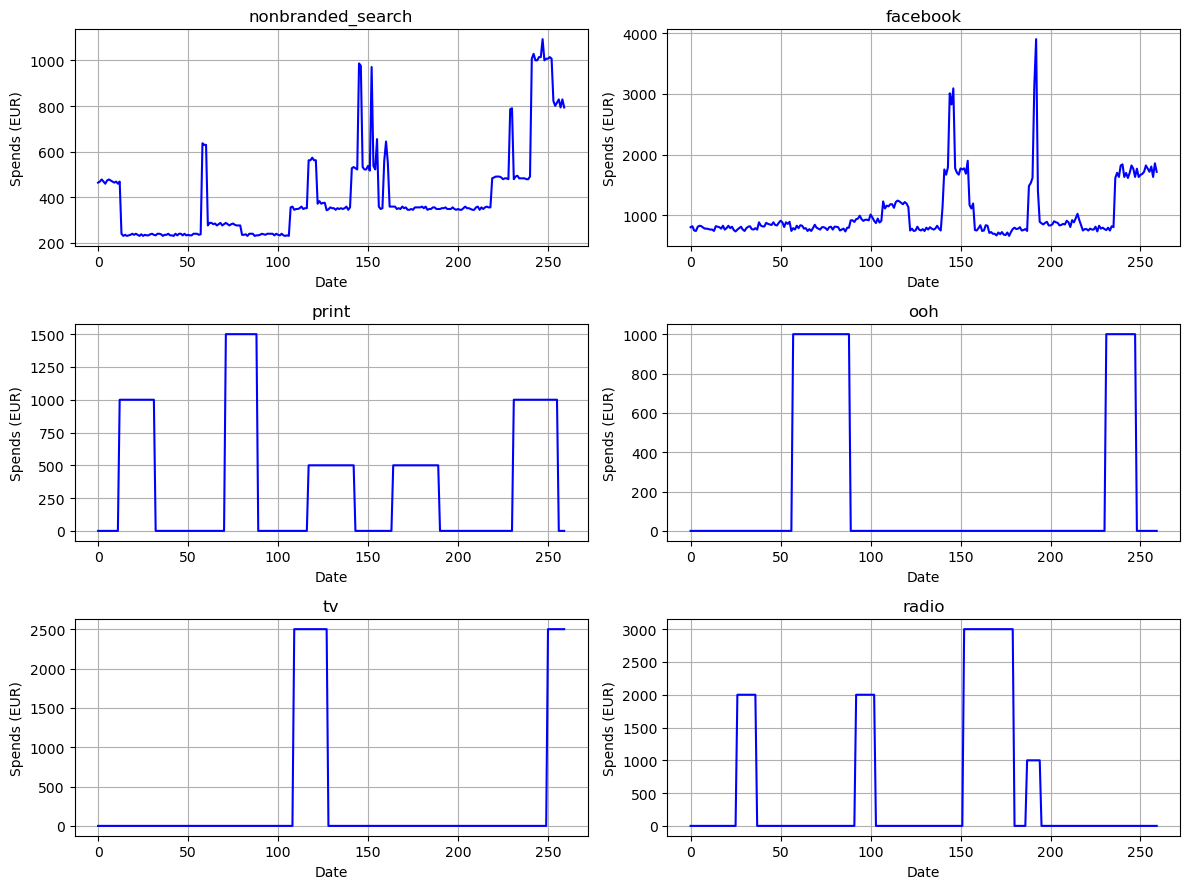

In [11]:
num_cols = len(mdsp_cols)
ncols = 2
nrows = math.ceil(num_cols / ncols)

plt.figure(figsize=(12, 3 * nrows)) 

for i, col in enumerate(mdsp_cols):
    plt.subplot(nrows, ncols, i + 1)
    plt.plot(df.index, df[col], label=col, color='b')
    plt.xlabel('Date')
    plt.ylabel('Spends (EUR)')
    plt.title(f'{col}')
    plt.grid(True)

plt.tight_layout()

plt.savefig("media_spends_timeseries.jpg", format='jpg', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
missing_cols = df[mdsp_cols].isnull().any()

missing_cols_list = missing_cols[missing_cols].index.tolist()

if missing_cols_list:
    print("Columns with NaN or null values:", missing_cols_list)
else:
    print("No NaN or null values found in the specified columns.")

No NaN or null values found in the specified columns.


In [13]:
control_vars = df.drop(['Week', 'sales'] + mdsp_cols, axis=1).columns
control_vars

Index([], dtype='object')

In [14]:
len(control_vars)

0

In [15]:
temp=df.copy()

In [16]:
# Split and scale data. 20% => test set.

SEED = 105
data_size = len(temp)

n_media_channels = len(mdsp_cols)
n_extra_features = len(control_vars)
media_data = temp[mdsp_cols].to_numpy()
extra_features = temp[control_vars].to_numpy()
target = temp['sales'].to_numpy()
costs = temp[mdsp_cols].sum().to_numpy()

test_data_period_size = int(0.2 * len(df))     
split_point = data_size - test_data_period_size
# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]
# Extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]
# Target
target_train = target[:split_point]

In [17]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean) 
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.max)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Checking data quality

### Correlation Test

In [18]:
correlations, variances, spend_fractions, variance_inflation_factors = preprocessing.check_data_quality(
    media_data=media_scaler.transform(media_data),
    target_data=target_scaler.transform(target),
    cost_data=costs,
    extra_features_data=extra_features_scaler.transform(extra_features) 
    )

In [19]:
correlations[0].style.background_gradient(cmap='RdBu', vmin=-1, vmax=1).format(precision=3)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,target
feature_0,1.000,0.573,0.070,0.091,0.298,-0.113,0.666
feature_1,0.573,1.000,-0.034,-0.004,0.214,-0.087,0.587
feature_2,0.070,-0.034,1.000,0.516,0.014,-0.105,-0.228
feature_3,0.091,-0.004,0.516,1.000,-0.171,-0.244,-0.236
feature_4,0.298,0.214,0.014,-0.171,1.000,-0.180,0.394
feature_5,-0.113,-0.087,-0.105,-0.244,-0.180,1.000,0.198
target,0.666,0.587,-0.228,-0.236,0.394,0.198,1.000


In [20]:
# save the results
correlation_df = correlations[0].copy()

custom_names = ['nonbranded_search', 'facebook', 'print', 'ooh', 'tv', 'radio']
full_names = custom_names + ['target']

# Replace both row and column names
correlation_df.index = full_names
correlation_df.columns = full_names

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df,
            annot=True,
            fmt=".3f",
            cmap="RdBu",
            vmin=-1,
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar=True,
            annot_kws={"size": 9})

plt.title("Correlation Heatmap", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()


plt.savefig("correlation_heatmap.jpg", dpi=300, bbox_inches='tight', facecolor='white')
plt.close()


### Variance Test

In [21]:
def highlight_variances(x: float, 
                        low_variance_threshold: float=1.0e-3, 
                        high_variance_threshold: float=3.0) -> str:

    if x < low_variance_threshold or x > high_variance_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'black'
    style = f'font-weight: {weight}; color: {color}'
    return style

variances.style.format(precision=4).applymap(highlight_variances)

,geo_0
feature_0,0.3364
feature_1,0.2217
feature_2,1.9223
feature_3,6.4619
feature_4,11.8763
feature_5,2.4908


In [22]:
# save the results

variances = pd.DataFrame({
    'variance': {
        'nonbranded_search': 0.3364,
        'facebook': 0.2217,
        'print': 1.9223,
        'ooh': 6.4619,
        'tv': 11.8763,
        'radio': 2.4908
    }
})

# Thresholds
low_threshold = 1e-3
high_threshold = 3.0

rounded_vals = variances.round(4).astype(str)


colors = []
for val in variances['variance']:
    if val < low_threshold or val > high_threshold:
        colors.append('red')
    else:
        colors.append('black')

# Plotting
fig, ax = plt.subplots(figsize=(4, 4)) 
fig.patch.set_facecolor('white')
ax.axis('off')

# Create table
table = ax.table(cellText=rounded_vals.values,
                 rowLabels=rounded_vals.index,
                 colLabels=rounded_vals.columns,
                 loc='center',
                 cellLoc='center')

table.scale(1, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(10)

# Apply text color and weight
for (row, col), cell in table.get_celld().items():
    if row == 0:  
        cell.set_text_props(weight='bold')
    elif col == 1:  
        continue
    else:
        color = colors[row - 1] 
        cell.get_text().set_color(color)
        if color == 'red':
            cell.get_text().set_weight('bold')


plt.savefig("variance_table.jpeg", dpi=300, bbox_inches='tight', facecolor='white')
plt.close()


### Spend Fraction Test

In [23]:
def highlight_low_spend_fractions(x: float,
                                  low_spend_threshold: float=0.01) -> str:
    if x < low_spend_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'black'
    style = f'font-weight: {weight}; color: {color}'
    return style

spend_fractions.style.format(precision=4).applymap(highlight_low_spend_fractions)

,fraction of spend
feature_0,0.1445
feature_1,0.3646
feature_2,0.1353
feature_3,0.0677
feature_4,0.1001
feature_5,0.1878


In [24]:
# Save the table
spend_fractions = np.array([0.1445, 0.3646, 0.1353,0.0677,0.1001, 0.1878]) #coming from above table

spend_df = pd.DataFrame({'Spend Fraction': spend_fractions}, index=mdsp_cols)
spend_df = spend_df.round(4)

fig, ax = plt.subplots(figsize=(5, 4))
fig.patch.set_facecolor('white')
ax.axis('off')

# Create the table
table = ax.table(cellText=spend_df.values,
                 rowLabels=spend_df.index,
                 colLabels=spend_df.columns,
                 cellLoc='center',
                 loc='center')

# Style
table.scale(1.5, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(10)

plt.savefig("spend_fraction_table.jpg", dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

### Checking the variance inflation factors

In [25]:
def highlight_high_vif_values(x: float,
                              high_vif_threshold: float=7.0) -> str:
    if x > high_vif_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'black'
    style = f'font-weight: {weight}; color: {color}'
    return style

variance_inflation_factors.style.format(precision=4).applymap(highlight_high_vif_values)

,geo_0
feature_0,1.6046
feature_1,1.5070
feature_2,1.3943
feature_3,1.5617
feature_4,1.2244
feature_5,1.1289


In [26]:
# Save the table
spend_fractions = np.array([1.6046, 1.5070, 1.3943, 1.5617, 1.2244, 1.1289]) #coming from above table

spend_df = pd.DataFrame({'Variance Inflation Factor': spend_fractions}, index=mdsp_cols)
spend_df = spend_df.round(4)

fig, ax = plt.subplots(figsize=(5, 4))
fig.patch.set_facecolor('white')
ax.axis('off')

# Create the table
table = ax.table(cellText=spend_df.values,
                 rowLabels=spend_df.index,
                 colLabels=spend_df.columns,
                 cellLoc='center',
                 loc='center')

# Style
table.scale(1.5, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(10)

plt.savefig("variance_inflation_factor_table.jpg", dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

# Modeling 

In [27]:
mdsp_cols

['nonbranded_search', 'facebook', 'print', 'ooh', 'tv', 'radio']

In [28]:
number_warmup= 1000
number_samples=2000
number_chains=2

mmm = lightweight_mmm.LightweightMMM(model_name="adstock")
mmm.fit( 
        weekday_seasonality=False, 
        seasonality_frequency=52,
        custom_priors={   
             "intercept": numpyro.distributions.HalfNormal(scale=10),
             "lag_weight": numpyro.distributions.Beta(concentration1=jnp.array([2, 2, 4.5,  4.5, 2,  4.5]), 
                                                            concentration0=jnp.array([11.3, 11.3, 13.5, 13.5, 1.63, 13.5]))  
                      },
        media=media_data_train, 
        extra_features=None, 
        media_prior=costs, 
        target=target_train, 
        number_warmup=number_warmup, 
        number_samples=number_samples, 
        media_names = mdsp_cols, 
        seed=SEED, 
        number_chains = number_chains)

/opt/conda/envs/lwmm/lib/python3.9/site-packages/lightweight_mmm/lightweight_mmm.py:357: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 3000/3000 [03:58<00:00, 12.58it/s, 1023 steps of size 4.26e-03. acc. prob=0.88]


In [29]:
mmm.print_summary()


                            mean       std    median      5.0%     95.0%     n_eff     r_hat
         coef_media[0]      0.14      0.06      0.13      0.05      0.24   2245.63      1.00
         coef_media[1]      0.35      0.12      0.32      0.18      0.53    610.13      1.00
         coef_media[2]      0.01      0.01      0.01      0.00      0.03   2632.17      1.00
         coef_media[3]      0.00      0.00      0.00      0.00      0.00   4937.96      1.00
         coef_media[4]      0.04      0.01      0.04      0.02      0.05   1915.05      1.00
         coef_media[5]      0.07      0.01      0.07      0.05      0.09   2239.67      1.00
         coef_trend[0]      0.00      0.00      0.00      0.00      0.00    610.01      1.01
            expo_trend      1.23      0.22      1.29      0.91      1.50    380.03      1.02
           exponent[0]      0.86      0.12      0.89      0.68      1.00   3753.08      1.00
           exponent[1]      0.78      0.14      0.80      0.58      1

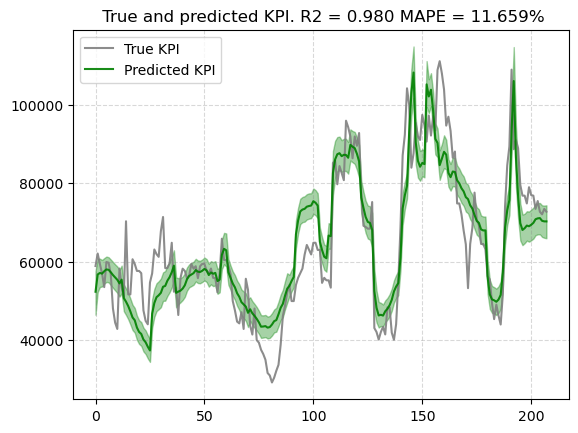

In [30]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

In [31]:
# save the plot
fig = plot.plot_model_fit(mmm, target_scaler=target_scaler)
fig.savefig("model_fit.jpeg", format='jpeg', dpi=300, bbox_inches='tight')


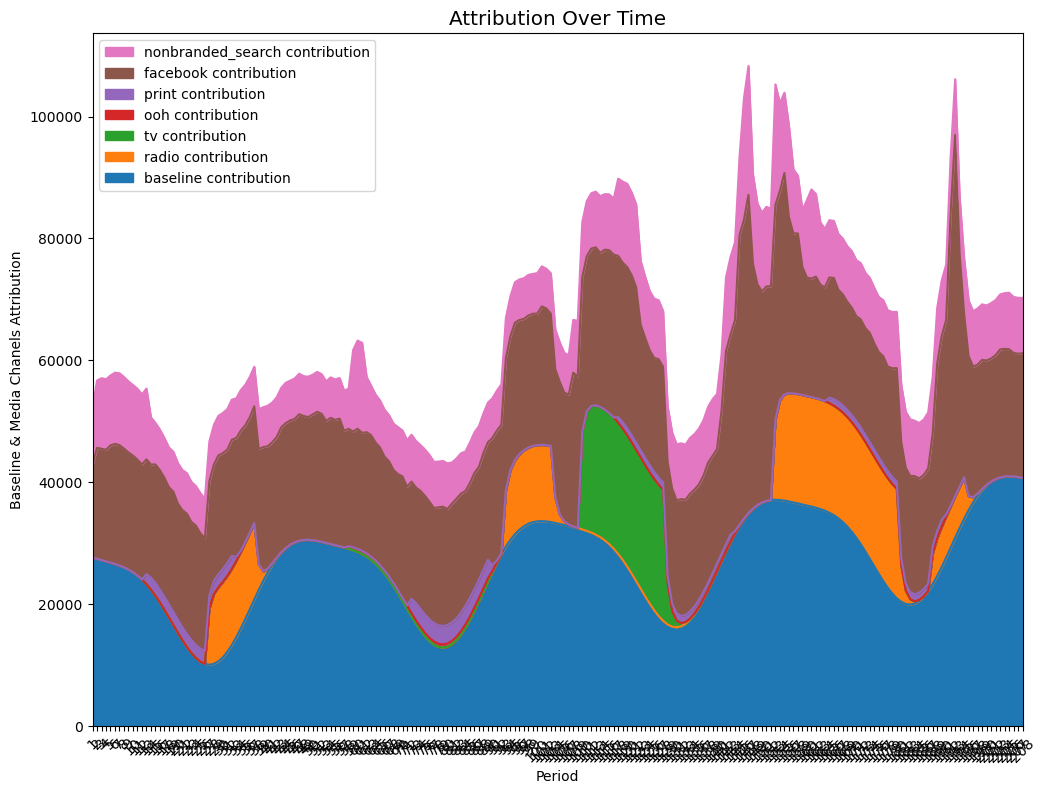

In [32]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(12, 9),
                                                channel_names = mdsp_cols)

In [33]:
# save the plot
fig = plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(12, 9),
                                                channel_names = mdsp_cols)
fig.savefig("Attribution_over_time.jpeg", format='jpeg', dpi=300, bbox_inches='tight')

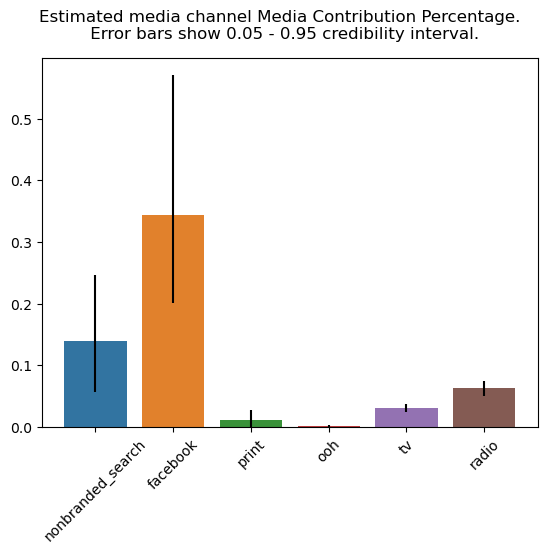

In [34]:
plot.plot_bars_media_metrics(metric=media_contribution, channel_names=mdsp_cols, metric_name="Media Contribution Percentage")


In [35]:
cont = plot.create_media_baseline_contribution_df(media_mix_model=mmm,
                                           target_scaler=target_scaler,
                                           channel_names = mdsp_cols)
cont.describe()

,nonbranded_search_percentage,facebook_percentage,print_percentage,ooh_percentage,tv_percentage,radio_percentage,baseline_percentage,avg_prediction,nonbranded_search contribution,facebook contribution,print contribution,ooh contribution,tv contribution,radio contribution,baseline contribution,period
count,208.000000,208.000000,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,208.000000,208.000000,208.000000,208.000000,208.000000,2.080000e+02,208.000000,208.000000,208.000000,208.000000
mean,0.142270,0.350362,1.490858e-02,1.647313e-03,2.475507e-02,5.572024e-02,0.410337,64110.644531,8947.338604,22017.103915,765.843498,8.084922e+01,1981.333011,4039.882491,26278.291016,104.500000
std,0.032163,0.066911,2.109109e-02,3.855163e-03,7.565840e-02,9.022330e-02,0.086217,16009.370117,2600.133878,6340.426716,976.270166,1.874128e+02,6102.634269,6618.134529,7877.226074,60.188592
min,0.086321,0.220698,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.206410,37266.074219,6457.052734,15168.602539,0.000000,0.000000e+00,0.000000,0.000000,10056.501953,1.000000
25%,0.118725,0.297215,8.636968e-07,0.000000e+00,0.000000e+00,5.104368e-11,0.352408,51557.394531,6637.518433,19005.240234,0.060621,0.000000e+00,0.000000,0.000003,20348.476074,52.750000
50%,0.135960,0.354574,4.191586e-04,4.626237e-19,0.000000e+00,4.825547e-06,0.416032,57776.826172,9079.711426,19695.795898,31.655586,4.059716e-14,0.000000,0.307250,27176.441406,104.500000
75%,0.163227,0.391565,2.243186e-02,4.112363e-09,1.740681e-08,9.015746e-02,0.467764,74329.666016,9286.624268,21564.600586,1170.121674,3.130557e-04,0.001524,6767.294067,32453.833008,156.250000
max,0.234880,0.558310,7.036424e-02,1.214318e-02,3.164234e-01,2.645417e-01,0.581511,108307.554688,21137.851562,59259.445312,3033.074951,5.233646e+02,21541.949219,17974.892578,40980.691406,208.000000


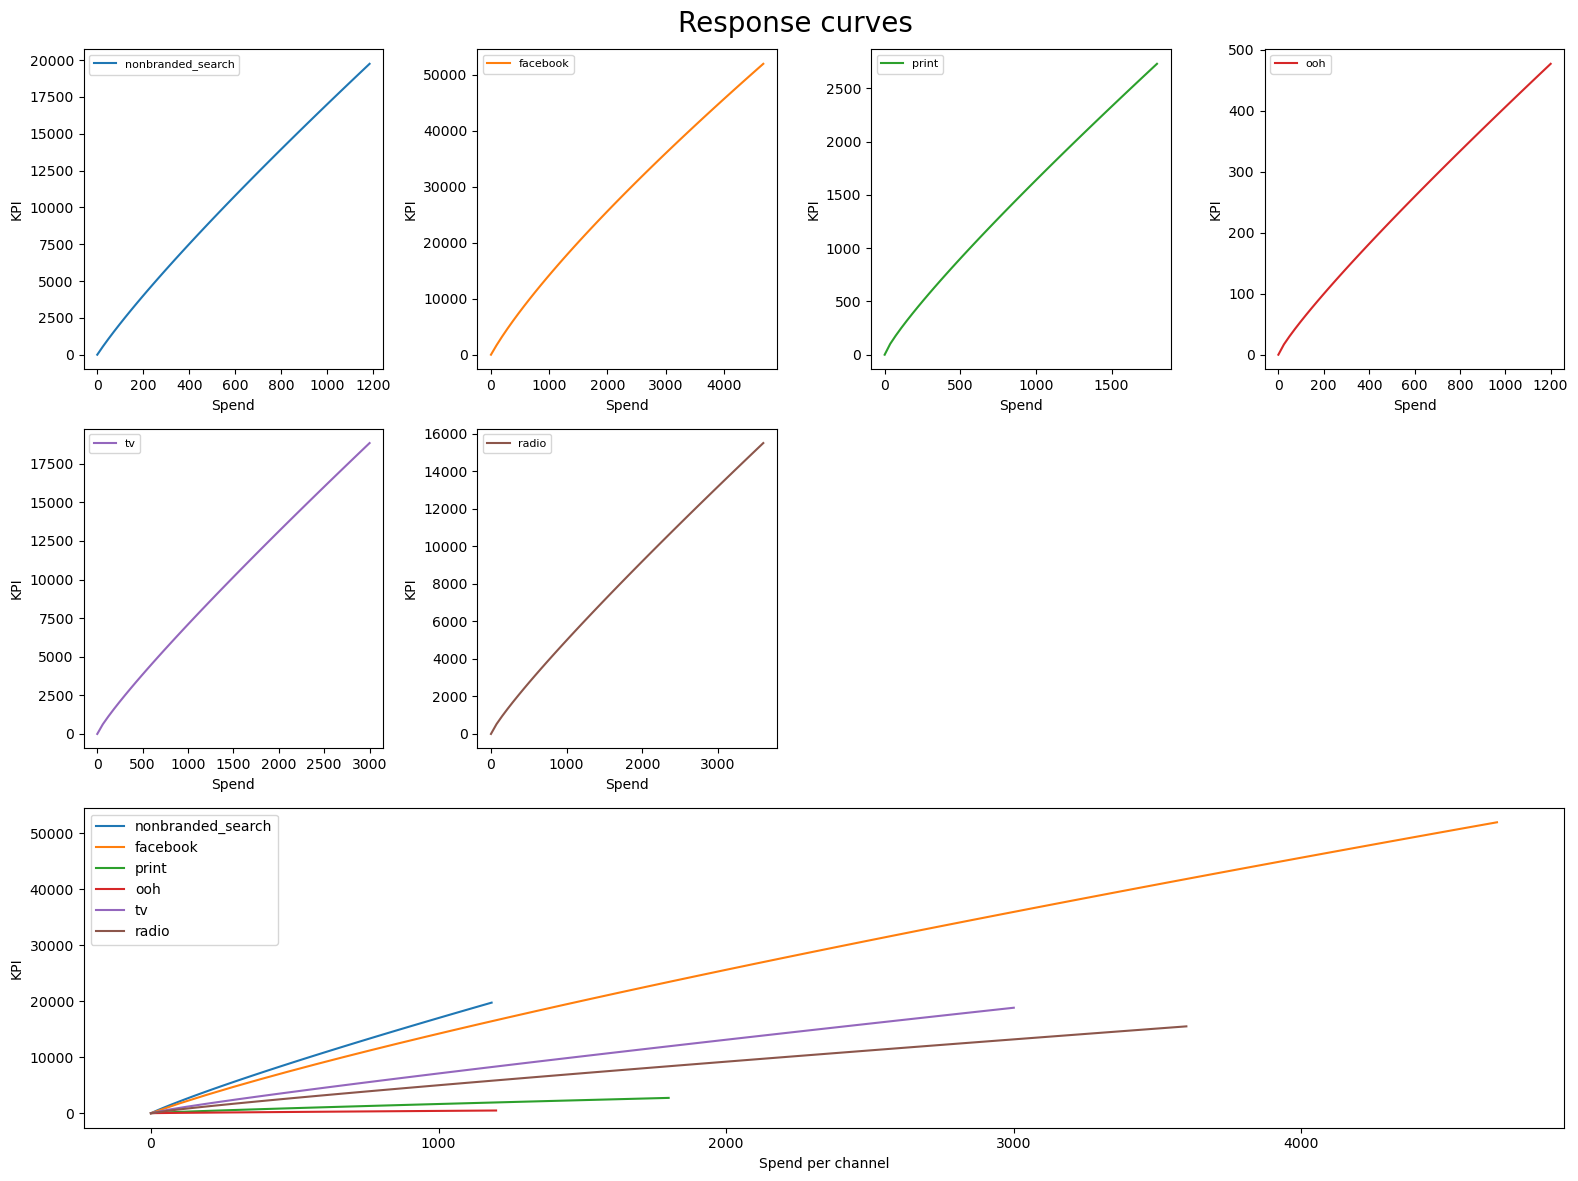

In [36]:
plot.plot_response_curves(
    media_mix_model=mmm, target_scaler=target_scaler, media_scaler=media_scaler, seed=SEED, n_columns= 4, figure_size=(16,12),  legend_fontsize=8)

In [37]:
# save the plot
fig = plot.plot_response_curves(
    media_mix_model=mmm, target_scaler=target_scaler, media_scaler=media_scaler, seed=SEED, n_columns= 4, figure_size=(16,12),  legend_fontsize=8)
fig.savefig("Response_Curves.jpeg", format='jpeg', dpi=300, bbox_inches='tight')

In [38]:
# prediction for test set
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test), seed=SEED)
new_predictions.shape

(4000, 52)

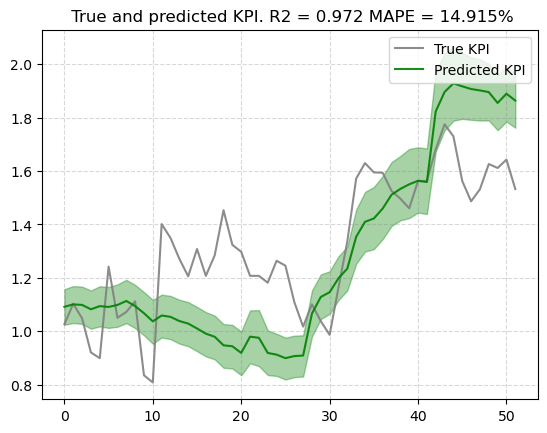

In [39]:
# prediction plot for test set
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                  out_of_sample_target=target_scaler.transform(target[split_point:]))

In [40]:
# save the plot
fig =plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                  out_of_sample_target=target_scaler.transform(target[split_point:]))
fig.savefig("Model_Fit_Testset.jpeg", format='jpeg', dpi=300, bbox_inches='tight')

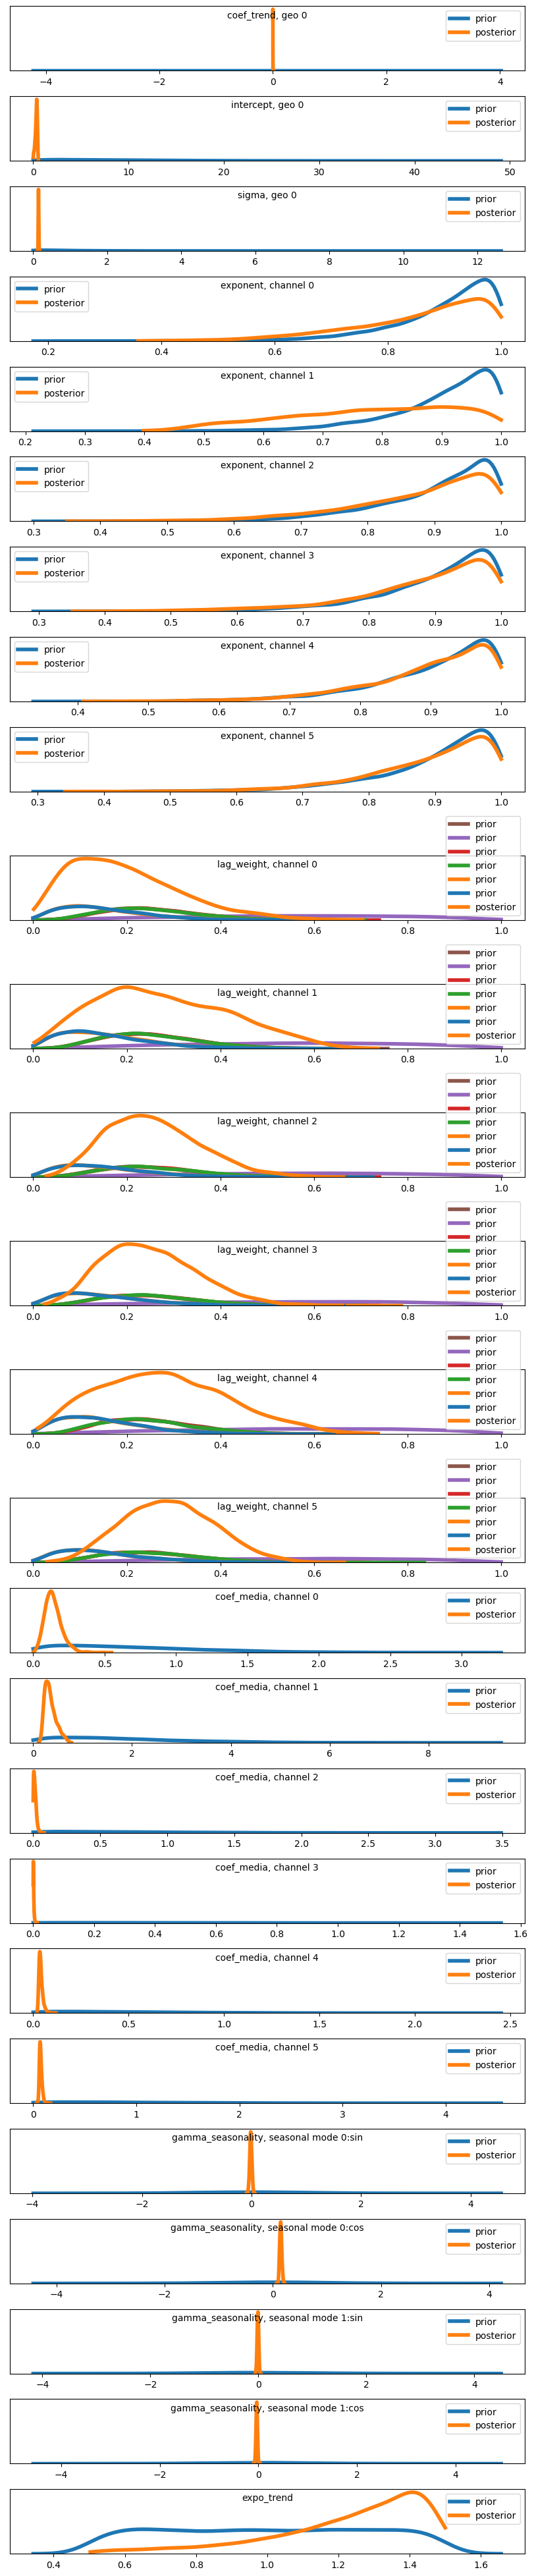

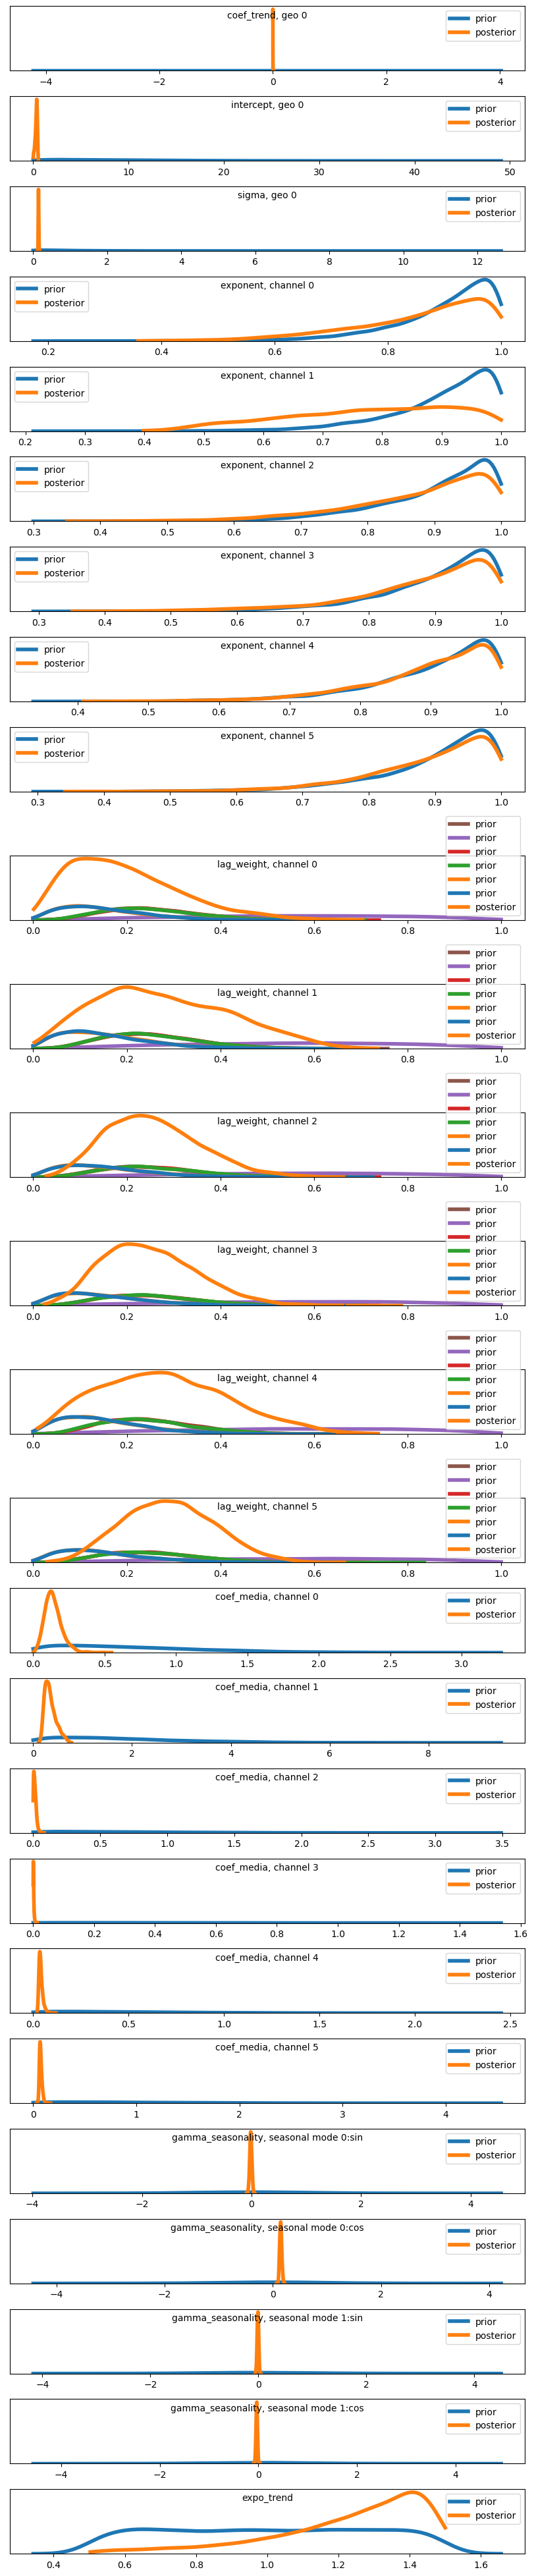

In [41]:
plot.plot_prior_and_posterior(media_mix_model=mmm)

In [42]:
# save the model
utils.save_model(media_mix_model=mmm, file_path='mmm_model')

In [43]:
cont.to_csv('mmm_results.csv', index= False)

## Contribution Analysis

In [44]:
# Adding same date range as original data to cont dataset
date_range = pd.date_range(start="2017-07-23", end="2021-07-17", freq='W')
cont["Week"] = date_range
cont

,nonbranded_search_percentage,facebook_percentage,print_percentage,ooh_percentage,tv_percentage,radio_percentage,baseline_percentage,avg_prediction,nonbranded_search contribution,facebook contribution,print contribution,ooh contribution,tv contribution,radio contribution,baseline contribution,period,Week
0,0.181301,0.290132,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.528567,52281.695312,9478.724609,15168.602539,0.000000,0.000000e+00,0.000000e+00,0.000000,27634.367188,1,2017-07-23
1,0.194766,0.321275,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.483959,56692.933594,11041.874023,18214.027344,0.000000,0.000000e+00,0.000000e+00,0.000000,27437.033203,2,2017-07-30
2,0.203064,0.319890,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.477046,57084.800781,11591.847656,18260.857422,0.000000,0.000000e+00,0.000000e+00,0.000000,27232.093750,3,2017-08-06
3,0.203713,0.321376,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.474910,56907.894531,11592.890625,18288.857422,0.000000,0.000000e+00,0.000000e+00,0.000000,27026.148438,4,2017-08-13
4,0.199311,0.334491,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.466199,57518.371094,11464.039062,19239.349609,0.000000,0.000000e+00,0.000000e+00,0.000000,26814.984375,5,2017-08-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.128620,0.295010,1.615715e-06,7.323319e-27,3.492890e-14,0.000051,0.576318,71029.148438,9135.757812,20954.279297,0.114763,5.201691e-22,2.480970e-09,3.609094,40935.390625,204,2021-06-13
204,0.130486,0.293129,1.169808e-06,4.833391e-27,2.566470e-14,0.000027,0.576357,71102.929688,9277.922852,20842.339844,0.083177,3.436683e-22,1.824835e-09,1.893242,40980.691406,205,2021-06-20
205,0.130463,0.288011,8.737871e-07,3.225413e-27,1.906557e-14,0.000014,0.581511,70411.492188,9186.108398,20279.265625,0.061525,2.271062e-22,1.342435e-09,1.016091,40945.039062,206,2021-06-27
206,0.130523,0.288069,6.587895e-07,2.136395e-27,1.405715e-14,0.000008,0.581399,70263.671875,9171.059570,20240.773438,0.046289,1.501109e-22,9.877069e-10,0.556604,40851.234375,207,2021-07-04


### Baseline and Marketing Channels Contribution

In [45]:
cont['total_marketing_contribution'] = (
    cont['nonbranded_search contribution'] +
    cont['facebook contribution'] +
    cont['print contribution'] +
    cont['ooh contribution'] +
    cont['tv contribution'] +
    cont['radio contribution']
)

channels_list = ['nonbranded_search', 'facebook', 'print', 'ooh', 'tv', 'radio']

cont_channel_level = []


for channel in channels_list:
    contribution_percentage = (
        sum(cont[f'{channel} contribution']) / sum(cont['total_marketing_contribution'])
    ) * 100

    cont_channel_level.append((channel, contribution_percentage))

cont_channel_level = pd.DataFrame(cont_channel_level, columns=['Channel', 'Contribution Percentage'])
cont_channel_level

,Channel,Contribution Percentage
0,nonbranded_search,23.649967
1,facebook,58.196500
2,print,2.024309
3,ooh,0.213704
4,tv,5.237140
5,radio,10.678381


In [46]:
baseline_cont = (cont['baseline contribution'].sum() / cont.avg_prediction.sum())*100
print(f'BaseLine Contribution is {round(baseline_cont, 2)} %')

BaseLine Contribution is 40.99 %


In [47]:
marketing_cont = (cont['total_marketing_contribution'].sum() / cont.avg_prediction.sum())*100
print(f'Marketing Contribution is {round(marketing_cont, 2)} %')

Marketing Contribution is 59.01 %


### Contribution of Seasonality

In [48]:
np.mean(mmm.trace['gamma_seasonality'], axis=0)

Array([[-0.01255026,  0.14557114],
       [-0.00893883, -0.03414898]], dtype=float32)

In [49]:
# Seasonality_effect

from lightweight_mmm.media_transforms import calculate_seasonality
 
gamma_seasonality = np.array(np.mean(mmm.trace['gamma_seasonality'], axis=0))
seasonality_component = calculate_seasonality(
    number_periods=len(cont), 
    degrees=mmm._degrees_seasonality , 
    gamma_seasonality=gamma_seasonality, 
    frequency=mmm._seasonality_frequency
)
seasonality_effect = target_scaler.inverse_transform(seasonality_component)
seasonality_effect

Array([  7142.442  ,   6903.914  ,   6663.21   ,   6421.3145 ,
         6173.6562 ,   5910.6367 ,   5618.544  ,   5280.7695 ,
         4879.2666 ,   4396.144  ,   3815.3098 ,   3124.0496 ,
         2314.4456 ,   1384.5317 ,    339.13058,   -809.7134 ,
        -2042.7249 ,  -3333.8228 ,  -4650.9673 ,  -5957.4106 ,
        -7213.2314 ,  -8377.143  ,  -9408.429  , -10268.909  ,
       -10924.859  , -11348.711  , -11520.513  , -11429.022  ,
       -11072.372  , -10458.289  ,  -9603.826  ,  -8534.652  ,
        -7283.908  ,  -5890.6978 ,  -4398.311  ,  -2852.255  ,
        -1298.2192 ,    219.96385,   1662.1498 ,   2993.539  ,
         4185.978  ,   5218.8774 ,   6079.7    ,   6763.992  ,
         7274.987  ,   7622.778  ,   7823.161  ,   7896.1895 ,
         7864.542  ,   7751.817  ,   7580.844  ,   7372.114  ,
         7142.442  ,   6903.915  ,   6663.2085 ,   6421.314  ,
         6173.656  ,   5910.6367 ,   5618.544  ,   5280.77   ,
         4879.266  ,   4396.1436 ,   3815.309  ,   3124

In [50]:
seasonality_effect_df = pd.DataFrame({
    'Week': date_range,
    'seasonality_effect': seasonality_effect
})
seasonality_effect_df

,Week,seasonality_effect
0,2017-07-23,7142.441895
1,2017-07-30,6903.914062
2,2017-08-06,6663.209961
3,2017-08-13,6421.314453
4,2017-08-20,6173.656250
...,...,...
203,2021-06-13,7896.188965
204,2021-06-20,7864.541016
205,2021-06-27,7751.816895
206,2021-07-04,7580.843262


### Contribution of trend

In [51]:
from lightweight_mmm.models import _COEF_TREND,  _EXPO_TREND
trend = mmm.trace[_COEF_TREND].reshape(1, -1) * np.arange(len(cont)).reshape(-1, 1) ** mmm.trace[_EXPO_TREND]
trend_decomp = np.mean(trend, axis=1)
trend_decomp_target = target_scaler.inverse_transform(trend_decomp)
trend_decomp_target.shape

(208,)

In [52]:
trend_decomp_target

Array([    0.      ,    41.19429 ,    76.96128 ,   112.909386,
         149.40118 ,   186.51471 ,   224.25899 ,   262.62152 ,
         301.5824  ,   341.12006 ,   381.21295 ,   421.84064 ,
         462.98398 ,   504.625   ,   546.74713 ,   589.33527 ,
         632.37494 ,   675.8529  ,   719.7569  ,   764.0755  ,
         808.79785 ,   853.91394 ,   899.4145  ,   945.29034 ,
         991.53314 ,  1038.135   ,  1085.0884  ,  1132.3864  ,
        1180.0219  ,  1227.9889  ,  1276.281   ,  1324.8926  ,
        1373.8179  ,  1423.0516  ,  1472.5889  ,  1522.4248  ,
        1572.5543  ,  1622.9733  ,  1673.6774  ,  1724.6622  ,
        1775.9242  ,  1827.4591  ,  1879.2633  ,  1931.3334  ,
        1983.6656  ,  2036.257   ,  2089.104   ,  2142.2036  ,
        2195.5527  ,  2249.1484  ,  2302.9878  ,  2357.0684  ,
        2411.387   ,  2465.9417  ,  2520.7295  ,  2575.7476  ,
        2630.9941  ,  2686.4668  ,  2742.163   ,  2798.0808  ,
        2854.2178  ,  2910.5718  ,  2967.141   ,  3023.

In [53]:
(trend_decomp_target.sum() / cont.avg_prediction.sum()) * 100

Array(9.025593, dtype=float32)

In [54]:
trend_effect_df = pd.DataFrame({
    'Week': date_range,
    'trend_effect': trend_decomp_target
})

trend_effect_df

,Week,trend_effect
0,2017-07-23,0.000000
1,2017-07-30,41.194290
2,2017-08-06,76.961281
3,2017-08-13,112.909386
4,2017-08-20,149.401184
...,...,...
203,2021-06-13,12547.269531
204,2021-06-20,12624.229492
205,2021-06-27,12701.294922
206,2021-07-04,12778.465820


## Contribution of intercept

In [55]:
intercept_target = target_scaler.inverse_transform(jnp.mean(mmm.trace['intercept']))
intercept_target

Array(20491.924, dtype=float32)

In [56]:
intercept_target * len(cont) / temp.sales.sum()

Array(0.24070074, dtype=float32)

In [57]:
num_days = len(cont)
intercept_effects = np.tile(intercept_target, num_days)[:num_days]

intercept_effect_df = pd.DataFrame({
    'Week': date_range,
    'intercept_effect': intercept_effects
})
intercept_effect_df

,Week,intercept_effect
0,2017-07-23,20491.923828
1,2017-07-30,20491.923828
2,2017-08-06,20491.923828
3,2017-08-13,20491.923828
4,2017-08-20,20491.923828
...,...,...
203,2021-06-13,20491.923828
204,2021-06-20,20491.923828
205,2021-06-27,20491.923828
206,2021-07-04,20491.923828


### Baseline Decomposition 

In [58]:
from functools import reduce
baseline_decomps_list = [intercept_effect_df, trend_effect_df, seasonality_effect_df]
baseline_decomps = reduce(lambda left, right: pd.merge(left, right, on='Week', how='left'), baseline_decomps_list)
baseline_decomps['baseline_estimate'] = baseline_decomps.drop(columns=['Week']).sum(axis=1)
baseline_decomps['Week'] = date_range
baseline_decomps['Week'] = pd.to_datetime(baseline_decomps['Week'], errors='coerce')
baseline_decomps

,Week,intercept_effect,trend_effect,seasonality_effect,baseline_estimate
0,2017-07-23,20491.923828,0.000000,7142.441895,27634.365234
1,2017-07-30,20491.923828,41.194290,6903.914062,27437.031250
2,2017-08-06,20491.923828,76.961281,6663.209961,27232.093750
3,2017-08-13,20491.923828,112.909386,6421.314453,27026.148438
4,2017-08-20,20491.923828,149.401184,6173.656250,26814.980469
...,...,...,...,...,...
203,2021-06-13,20491.923828,12547.269531,7896.188965,40935.382812
204,2021-06-20,20491.923828,12624.229492,7864.541016,40980.695312
205,2021-06-27,20491.923828,12701.294922,7751.816895,40945.035156
206,2021-07-04,20491.923828,12778.465820,7580.843262,40851.234375


In [59]:
# Error between estimated baseline and and baseline cont from the model
(cont['baseline contribution'] - baseline_decomps['baseline_estimate']).describe()

count    208.000000
mean       0.002657
std        0.006809
min       -0.017578
25%        0.000000
50%        0.001953
75%        0.003906
max        0.031250
dtype: float64

In [60]:
baseline_decomps

,Week,intercept_effect,trend_effect,seasonality_effect,baseline_estimate
0,2017-07-23,20491.923828,0.000000,7142.441895,27634.365234
1,2017-07-30,20491.923828,41.194290,6903.914062,27437.031250
2,2017-08-06,20491.923828,76.961281,6663.209961,27232.093750
3,2017-08-13,20491.923828,112.909386,6421.314453,27026.148438
4,2017-08-20,20491.923828,149.401184,6173.656250,26814.980469
...,...,...,...,...,...
203,2021-06-13,20491.923828,12547.269531,7896.188965,40935.382812
204,2021-06-20,20491.923828,12624.229492,7864.541016,40980.695312
205,2021-06-27,20491.923828,12701.294922,7751.816895,40945.035156
206,2021-07-04,20491.923828,12778.465820,7580.843262,40851.234375


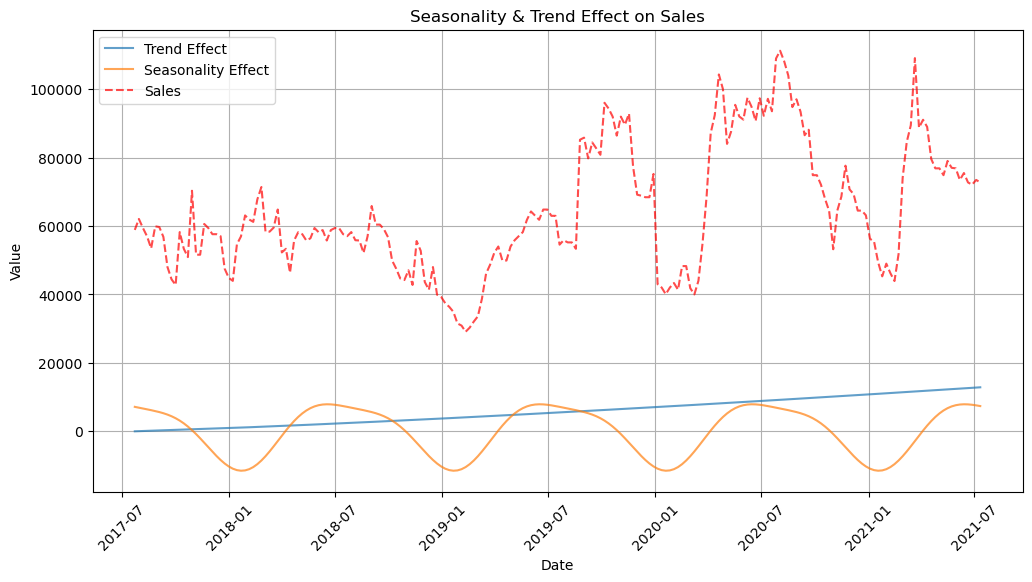

In [61]:
merged_df = pd.merge(baseline_decomps, temp[['Week', 'sales']], on='Week', how='left')

plt.figure(figsize=(12, 6))
plt.plot(merged_df['Week'], merged_df['trend_effect'], label="Trend Effect", alpha=0.7)
plt.plot(merged_df['Week'], merged_df['seasonality_effect'], label="Seasonality Effect", alpha=0.7)



plt.plot(merged_df['Week'], merged_df['sales'], label="Sales", alpha=0.7, linestyle="dashed", color="red")

plt.title("Seasonality & Trend Effect on Sales")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend(loc="upper left")
plt.xticks(rotation=45)
plt.grid(True)

#save the plot
plt.savefig("Sales_Trend_Seasonality.jpeg", format='jpeg', dpi=300, bbox_inches='tight')
plt.show()

## plotting residuals of the model

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'date' column is in datetime format
temp['Week'] = pd.to_datetime(temp['Week'], errors='coerce')
cont['Week'] = pd.to_datetime(cont['Week'], errors='coerce')

# Merge temp and cont on 'date' to align data
merged_df = pd.merge(temp, cont[['Week', 'avg_prediction']], on='Week', how='left')

# Calculate the difference
merged_df['sales_difference'] = merged_df['sales'] - merged_df['avg_prediction']
merged_df

,Week,sales,nonbranded_search,facebook,print,ooh,tv,radio,avg_prediction,sales_difference
0,2017-07-23,58850.0000,463.3200,802.6200,0,0,0,0,52281.695312,6568.304688
1,2017-07-30,62050.0000,468.0000,819.3120,0,0,0,0,56692.933594,5357.066406
2,2017-08-06,59388.0000,477.3600,749.0340,0,0,0,0,57084.800781,2303.199219
3,2017-08-13,56964.0000,468.0000,741.4680,0,0,0,0,56907.894531,56.105469
4,2017-08-20,53460.0000,458.6400,811.2000,0,0,0,0,57518.371094,-4058.371094
...,...,...,...,...,...,...,...,...,...,...
255,2022-06-12,98173.4880,814.9285,1715.8284,1000,0,2500,0,NaN,NaN
256,2022-06-19,104221.7248,829.0855,1802.8296,0,0,2500,0,NaN,NaN
257,2022-06-26,103283.6800,793.6930,1631.2296,0,0,2500,0,NaN,NaN
258,2022-07-03,105279.5200,829.0855,1855.8540,0,0,2500,0,NaN,NaN


In [63]:
merged_df['sales_difference'].describe()

count      208.000000
mean        -8.121715
std       8923.046019
min     -22758.148125
25%      -5914.952930
50%        156.519531
75%       5479.913945
max      26583.225937
Name: sales_difference, dtype: float64

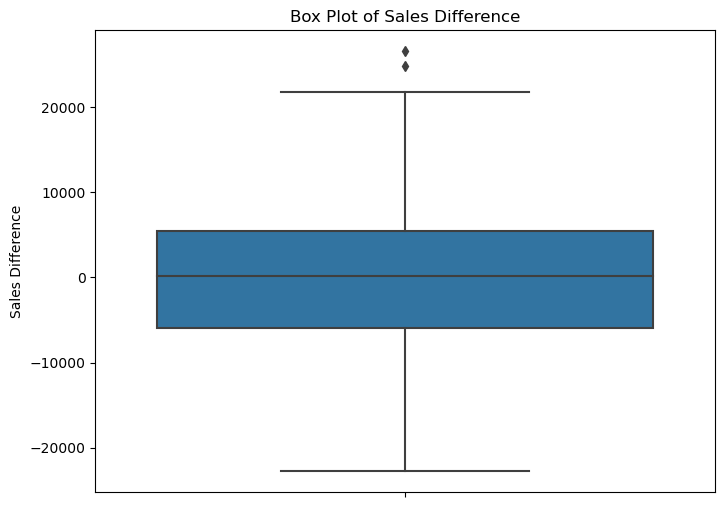

In [64]:

plt.figure(figsize=(8, 6))
sns.boxplot(y=merged_df['sales_difference'])

# Set labels and title
plt.ylabel('Sales Difference')
plt.title('Box Plot of Sales Difference')

# Show the plot
plt.show()

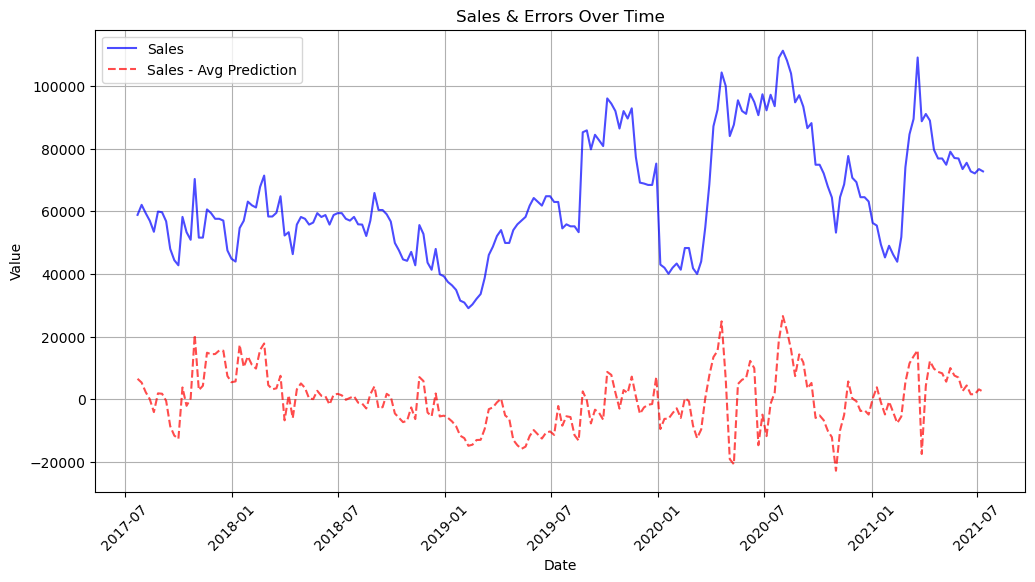

In [67]:
plt.figure(figsize=(12, 6))

# Plot sales
plt.plot(merged_df['Week'][:split_point], merged_df['sales'][:split_point], label="Sales", alpha=0.7, color="blue")

# Plot sales difference (sales - avg_prediction)
plt.plot(merged_df['Week'][:split_point], merged_df['sales_difference'][:split_point], label="Sales - Avg Prediction", alpha=0.7, linestyle="dashed", color="red")

# Formatting
plt.title("Sales & Errors Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend(loc="upper left")
plt.xticks(rotation=45)
plt.grid(True)

#save the plot
plt.savefig("Sales_Errors.jpeg", format='jpeg', dpi=300, bbox_inches='tight')
plt.show()

## Budget Optimization

In [68]:
prices = jnp.ones(mmm.n_media_channels)
prices

Array([1., 1., 1., 1., 1., 1.], dtype=float32)

In [69]:
n_time_periods = 20
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods
budget

Array(55699.082, dtype=float32)

In [70]:
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=SEED)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1607290.7242960022
            Iterations: 21
            Function evaluations: 261
            Gradient evaluations: 20


In [71]:
# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

Array([ 8262.433 , 23050.348 ,  5615.385 ,  2461.5383,  5480.7705,
       10828.608 ], dtype=float32)

In [72]:
# similar renormalization to get previous budget allocation
previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation

Array([ 7123.8564, 19873.97  ,  7262.363 ,  3183.5015,  4725.5107,
       13529.882 ], dtype=float32)

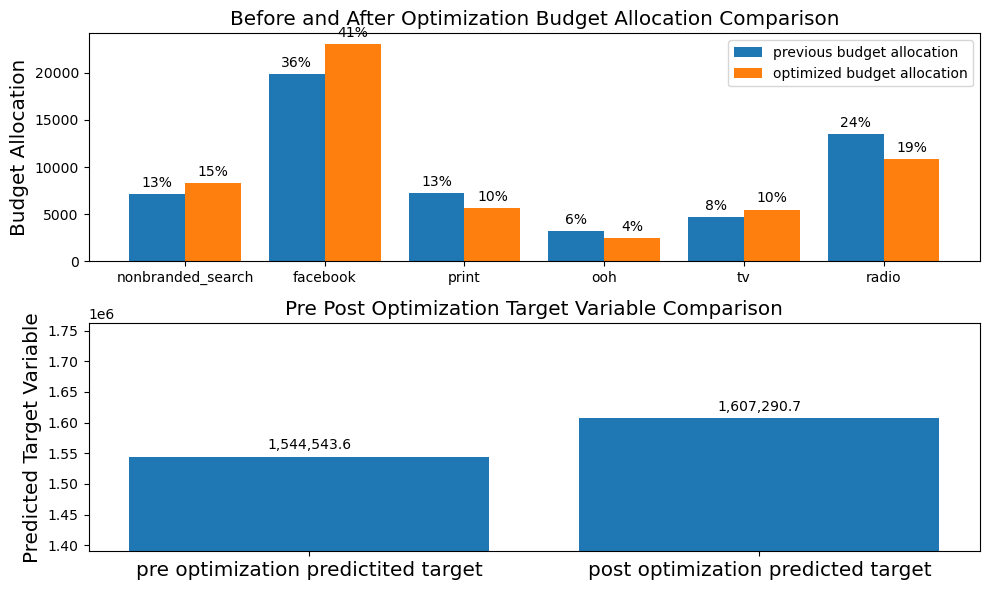

In [73]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm, 
                                                kpi_with_optim=solution['fun'], 
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation, 
                                                previous_budget_allocation=previous_budget_allocation, 
                                                figure_size=(10,6))

In [74]:
# Save the plot
fig = plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm, 
                                                kpi_with_optim=solution['fun'], 
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation, 
                                                previous_budget_allocation=previous_budget_allocation, 
                                                figure_size=(10,6))

fig.savefig("Budget_optimization.jpeg", format='jpeg', dpi=300, bbox_inches='tight')

### Visuals

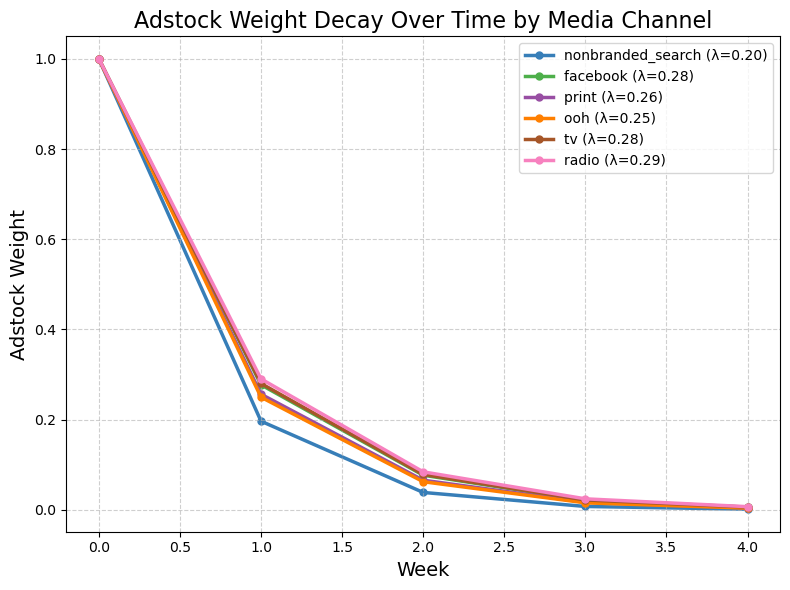

In [75]:
# lag weights are coming from model results.
lag_weights = np.array(np.mean(mmm.trace['lag_weight'], axis=0))


# Time (Weeks)
days = np.arange(0, 5)
colors = [
    "#377eb8",  # blue
    "#4daf4a",  # green
    "#984ea3",  # purple
    "#ff7f00",  # orange
    "#a65628",  # brown
    "#f781bf"   # pink
]

# Plotting
plt.figure(figsize=(8, 6))
for i, (media, lam) in enumerate(zip(mdsp_cols, lag_weights)):
    weights = lam ** days
    plt.plot(
        days, weights, 
        label=f'{media} (λ={lam:.2f})', 
        color=colors[i], 
        linewidth=2.5, 
        marker='o', 
        markersize=5,
        zorder=i
    )

# Styling
plt.title('Adstock Weight Decay Over Time by Media Channel', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Adstock Weight', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.style.use('default')

#save the plot
plt.savefig("Adstock.jpeg", format='jpeg', dpi=300, bbox_inches='tight')
plt.show()


In [76]:
cont

,nonbranded_search_percentage,facebook_percentage,print_percentage,ooh_percentage,tv_percentage,radio_percentage,baseline_percentage,avg_prediction,nonbranded_search contribution,facebook contribution,print contribution,ooh contribution,tv contribution,radio contribution,baseline contribution,period,Week,total_marketing_contribution
0,0.181301,0.290132,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.528567,52281.695312,9478.724609,15168.602539,0.000000,0.000000e+00,0.000000e+00,0.000000,27634.367188,1,2017-07-23,24647.327148
1,0.194766,0.321275,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.483959,56692.933594,11041.874023,18214.027344,0.000000,0.000000e+00,0.000000e+00,0.000000,27437.033203,2,2017-07-30,29255.901367
2,0.203064,0.319890,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.477046,57084.800781,11591.847656,18260.857422,0.000000,0.000000e+00,0.000000e+00,0.000000,27232.093750,3,2017-08-06,29852.705078
3,0.203713,0.321376,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.474910,56907.894531,11592.890625,18288.857422,0.000000,0.000000e+00,0.000000e+00,0.000000,27026.148438,4,2017-08-13,29881.748047
4,0.199311,0.334491,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.466199,57518.371094,11464.039062,19239.349609,0.000000,0.000000e+00,0.000000e+00,0.000000,26814.984375,5,2017-08-20,30703.388672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.128620,0.295010,1.615715e-06,7.323319e-27,3.492890e-14,0.000051,0.576318,71029.148438,9135.757812,20954.279297,0.114763,5.201691e-22,2.480970e-09,3.609094,40935.390625,204,2021-06-13,30093.760966
204,0.130486,0.293129,1.169808e-06,4.833391e-27,2.566470e-14,0.000027,0.576357,71102.929688,9277.922852,20842.339844,0.083177,3.436683e-22,1.824835e-09,1.893242,40980.691406,205,2021-06-20,30122.239115
205,0.130463,0.288011,8.737871e-07,3.225413e-27,1.906557e-14,0.000014,0.581511,70411.492188,9186.108398,20279.265625,0.061525,2.271062e-22,1.342435e-09,1.016091,40945.039062,206,2021-06-27,29466.451639
206,0.130523,0.288069,6.587895e-07,2.136395e-27,1.405715e-14,0.000008,0.581399,70263.671875,9171.059570,20240.773438,0.046289,1.501109e-22,9.877069e-10,0.556604,40851.234375,207,2021-07-04,29412.435900


In [77]:
df

,Week,sales,nonbranded_search,facebook,print,ooh,tv,radio
0,2017-07-23,58850.0000,463.3200,802.6200,0,0,0,0
1,2017-07-30,62050.0000,468.0000,819.3120,0,0,0,0
2,2017-08-06,59388.0000,477.3600,749.0340,0,0,0,0
3,2017-08-13,56964.0000,468.0000,741.4680,0,0,0,0
4,2017-08-20,53460.0000,458.6400,811.2000,0,0,0,0
...,...,...,...,...,...,...,...,...
255,2022-06-12,98173.4880,814.9285,1715.8284,1000,0,2500,0
256,2022-06-19,104221.7248,829.0855,1802.8296,0,0,2500,0
257,2022-06-26,103283.6800,793.6930,1631.2296,0,0,2500,0
258,2022-07-03,105279.5200,829.0855,1855.8540,0,0,2500,0


In [78]:
# Merging original df containing marketing spend with contrbution table for further visuals
df_cont = df.iloc[:208].merge(cont, on='Week', how='left')
df_cont

,Week,sales,nonbranded_search,facebook,print,ooh,tv,radio,nonbranded_search_percentage,facebook_percentage,print_percentage,ooh_percentage,tv_percentage,radio_percentage,baseline_percentage,avg_prediction,nonbranded_search contribution,facebook contribution,print contribution,ooh contribution,tv contribution,radio contribution,baseline contribution,period,total_marketing_contribution
0,2017-07-23,58850.00,463.32,802.6200,0,0,0,0,0.181301,0.290132,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.528567,52281.695312,9478.724609,15168.602539,0.000000,0.000000e+00,0.000000e+00,0.000000,27634.367188,1,24647.327148
1,2017-07-30,62050.00,468.00,819.3120,0,0,0,0,0.194766,0.321275,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.483959,56692.933594,11041.874023,18214.027344,0.000000,0.000000e+00,0.000000e+00,0.000000,27437.033203,2,29255.901367
2,2017-08-06,59388.00,477.36,749.0340,0,0,0,0,0.203064,0.319890,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.477046,57084.800781,11591.847656,18260.857422,0.000000,0.000000e+00,0.000000e+00,0.000000,27232.093750,3,29852.705078
3,2017-08-13,56964.00,468.00,741.4680,0,0,0,0,0.203713,0.321376,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.474910,56907.894531,11592.890625,18288.857422,0.000000,0.000000e+00,0.000000e+00,0.000000,27026.148438,4,29881.748047
4,2017-08-20,53460.00,458.64,811.2000,0,0,0,0,0.199311,0.334491,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.466199,57518.371094,11464.039062,19239.349609,0.000000,0.000000e+00,0.000000e+00,0.000000,26814.984375,5,30703.388672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,2021-06-13,75467.70,351.00,883.7400,0,0,0,0,0.128620,0.295010,1.615715e-06,7.323319e-27,3.492890e-14,0.000051,0.576318,71029.148438,9135.757812,20954.279297,0.114763,5.201691e-22,2.480970e-09,3.609094,40935.390625,204,30093.760966
204,2021-06-20,72723.42,358.02,874.9026,0,0,0,0,0.130486,0.293129,1.169808e-06,4.833391e-27,2.566470e-14,0.000027,0.576357,71102.929688,9277.922852,20842.339844,0.083177,3.436683e-22,1.824835e-09,1.893242,40980.691406,205,30122.239115
205,2021-06-27,72072.00,351.00,832.2600,0,0,0,0,0.130463,0.288011,8.737871e-07,3.225413e-27,1.906557e-14,0.000014,0.581511,70411.492188,9186.108398,20279.265625,0.061525,2.271062e-22,1.342435e-09,1.016091,40945.039062,206,29466.451639
206,2021-07-04,73458.00,351.00,840.9258,0,0,0,0,0.130523,0.288069,6.587895e-07,2.136395e-27,1.405715e-14,0.000008,0.581399,70263.671875,9171.059570,20240.773438,0.046289,1.501109e-22,9.877069e-10,0.556604,40851.234375,207,29412.435900


/tmp/ipykernel_3604/1484017619.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")
/tmp/ipykernel_3604/1484017619.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([format_millions(y) for y in y_ticks], fontsize=12, color="black")


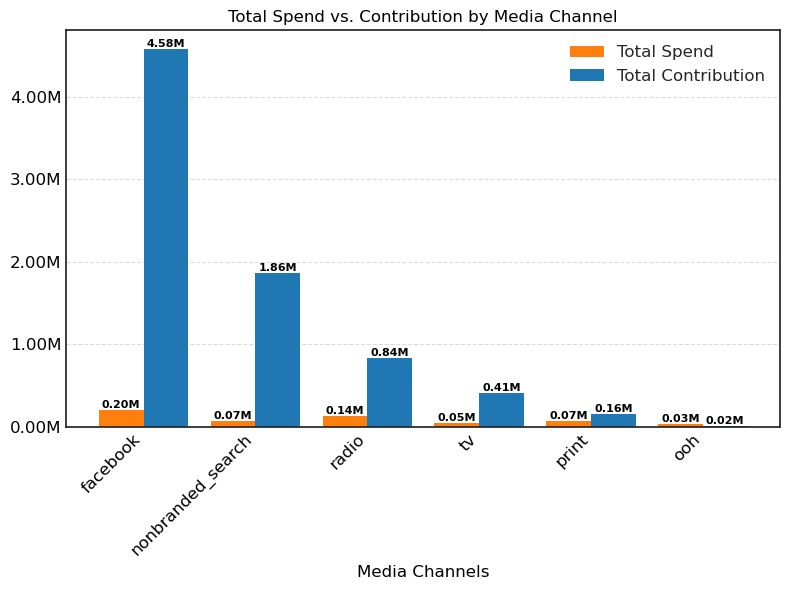

In [79]:
plt.style.use("seaborn-white")


contribution_columns = ['nonbranded_search contribution', 'facebook contribution', 
                        'print contribution', 'ooh contribution', 'tv contribution', 
                        'radio contribution']

# Aggregate total spend and contributions
total_spend = df_cont[mdsp_cols].sum().values 
total_contribution = df_cont[contribution_columns].sum().values

df = pd.DataFrame({"Media": mdsp_cols, "Spend": total_spend, "Contribution": total_contribution})
# Sort by Contribution in descending order
df = df.sort_values(by="Contribution", ascending=False)


custom_colors = ["#ff7f0e", "#1f77b4"]  


fig, ax = plt.subplots(figsize=(8, 6))
width = 0.4
x = range(len(df))

bars1 = ax.bar(x, df["Spend"], width=width, color=custom_colors[0], label="Total Spend")
bars2 = ax.bar([i + width for i in x], df["Contribution"], width=width, color=custom_colors[1], label="Total Contribution")

def format_millions(value):
    return f"{value / 1_000_000:.2f}M"

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, 
            format_millions(bar.get_height()), ha="center", va="bottom", 
            fontsize=8, fontweight="bold", color="black")

for bar in bars2:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, 
            format_millions(bar.get_height()), ha="center", va="bottom", 
            fontsize=8, fontweight="bold", color="black")

# Formatting X-axis
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(df["Media"], rotation=45, ha="right", fontsize=12, color="black")

# Formatting Y-axis labels in Millions
y_ticks = ax.get_yticks()
ax.set_yticklabels([format_millions(y) for y in y_ticks], fontsize=12, color="black")

ax.set_ylabel("", fontsize=12, color="black")
ax.set_xlabel("Media Channels", fontsize=12, color="black")
ax.set_title("Total Spend vs. Contribution by Media Channel", fontsize=12, color="black")
ax.legend(fontsize=12, loc="upper right", frameon=False)
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

#save the plot
plt.savefig("Media_Contribution.jpeg", format='jpeg', dpi=300, bbox_inches='tight')
plt.show()
